In [1]:
#!git clone https://github.com/TheMrGhostman/Semi-supervised-Learning-with-VAE

In [2]:
#!pip install pyro-ppl

In [3]:
import os
import time

import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision

from pyro.infer import SVI, JitTrace_ELBO, JitTraceEnum_ELBO, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam

import matplotlib.pyplot as plt


In [4]:
#os.chdir("Semi-supervised-Learning-with-VAE/")

In [5]:
from utils.datasets import SupervisedDataset
from utils.utils import One_Hot

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from utils.layers import Reshape, Flatten
import utils.datasets as d

In [7]:
class VariationalLayer(nn.Module):
    """
    Variational Layer with reparametrization trick. 
    It's used as bottleneck of Variational AutoEncoder ie. output of encoder.

    "Linear layer for variational inference with reparametrization trick"
    """
    def __init__(self, in_features, out_features, bias=True):
        """	
        : param in_features: 		Number of input features (number of neurons on input)
        : param out_features:		Number of output features (number of neurons on output)
        : param bias:				Include bias - True/False
        """
        super(VariationalLayer, self).__init__()
        self.mu = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
        self.rho = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
        self.softplus = nn.Softplus()

    def forward(self, x_in):
        mu = self.mu(x_in)
        sigma = self.softplus(self.rho(x_in))
        return mu, sigma

In [8]:
class ConvTransposeDecoderOutput(nn.Module):
    def __init__(self, in_channels, in_features, out_features, kernel_size, stride=1, padding=0, bias=True):
        super(ConvTransposeDecoderOutput, self).__init__()
        self.mu = nn.ConvTranspose1d(
                in_channels=in_channels, 
                out_channels=1, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding
            )
        self.rho = nn.Linear(in_features=in_features, out_features=1, bias=bias)
        self.flatten = Flatten(out_features=in_features)
        self.flatten_mu = Flatten(out_features=out_features)
        self.softplus = nn.Softplus()

    def forward(self, x_in):
        """
        x must be shape ... (-1, in_channels, size)
        """
        mu = self.mu(x_in)
        x = self.flatten(x_in)
        sigma = self.softplus(self.rho(x))
        return self.flatten_mu(mu), sigma

In [9]:
class ConvTransposeDecoderOutput2(nn.Module):
    def __init__(self, in_channels, out_features, kernel_size, stride=1, padding=0, bias=True):
        super(ConvTransposeDecoderOutput2, self).__init__()
        self.mu = nn.ConvTranspose1d(
                in_channels=in_channels, 
                out_channels=1, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding
            )
        self.flatten_mu = Flatten(out_features=out_features)

    def forward(self, x_in):
        """
        x must be shape ... (-1, in_channels, size)
        """
        mu = self.mu(x_in)
        return self.flatten_mu(mu)

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.first_part =  nn.Sequential(
                Reshape(out_shape=(1, 160)),
                nn.Conv1d(in_channels=1, out_channels=16, kernel_size=6, stride=2, padding=0, bias=False), # n*1*160 -> n*16*78
                nn.PReLU(),
                nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, stride=2, bias=False),#n*16*78->n*32*38
                nn.BatchNorm1d(num_features=32),
                nn.PReLU(),
                nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, bias=False),#n*32*38->n*64*18
                nn.BatchNorm1d(num_features=64),
                nn.PReLU(),
                Flatten(out_features=64*18))
        self.fc = nn.Linear(in_features=64*18+4, out_features=256)
        self.act = nn.PReLU()
        self.out = VariationalLayer(in_features=256, out_features=15)
        
    def forward(self, x,y):
        z = self.first_part(x)
        z = torch.cat([z,y], axis=1)
        z = self.act(self.fc(z))
        return self.out(z)
        

In [11]:
decoder = nn.Sequential(
    nn.Linear(in_features=15+4, out_features=256),
    nn.PReLU(),
    nn.Linear(in_features=256, out_features=64*18),
    Reshape(out_shape=(64,18)),
    nn.BatchNorm1d(num_features=64),
    nn.PReLU(),
    nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0),
    nn.BatchNorm1d(num_features=32),
    nn.PReLU(),
    nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=0),
    #nn.BatchNorm1d(num_features=16),
    nn.PReLU(),
    ConvTransposeDecoderOutput(
        in_channels=16,
        in_features=16*78,
        out_features=160, 
        kernel_size=6, 
        stride=2
        )
    )

In [12]:
clf = nn.Sequential(
    Reshape(out_shape=(1, 160)),
    nn.Conv1d(in_channels=1, out_channels=16, kernel_size=6, stride=2, padding=0, bias=False), # n*1*160 -> n*16*78
    nn.PReLU(),
    nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, stride=2, bias=False),#n*16*78->n*32*38
    nn.BatchNorm1d(num_features=32),
    nn.PReLU(),
    nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, bias=False),#n*32*38->n*64*18
    nn.BatchNorm1d(num_features=64),
    nn.PReLU(),
    Flatten(out_features=64*18),
    nn.Linear(in_features=64*18, out_features=256),
    nn.PReLU(),
    nn.Linear(in_features=256, out_features=4),
    nn.Softmax(dim=1)
    )

In [13]:
class SSVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks) and models & guides needed to train a
    semi-supervised variational auto-encoder on the MNIST image dataset
    :param output_size: size of the tensor representing the class label (10 for MNIST since
                        we represent the class labels as a one-hot vector with 10 components)
    :param input_size: size of the tensor representing the image (28*28 = 784 for our MNIST dataset
                       since we flatten the images and scale the pixels to be in [0,1])
    :param z_dim: size of the tensor representing the latent random variable z
                  (handwriting style for our MNIST dataset)
    :param hidden_layers: a tuple (or list) of MLP layers to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """
    def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):

        super().__init__()

        # initialize the class with all arguments provided to the constructor
        self.output_size = 4
        self.z_dim = 15
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        # define and instantiate the neural networks representing
        # the paramters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):

        self.encoder_y = clf

        self.encoder_z = Encoder()

        self.decoder = decoder

        if self.use_cuda:
            self.cuda()

    def model(self, xs, ys=None):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # handwriting style (latent)
        p(y|x) = categorical(I/10.)     # which digit (semi-supervised)
        p(x|y,z) = bernoulli(loc(y,z))   # an image
        loc is given by a neural network  `decoder`
        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)

        batch_size = xs.size(0)
        options = dict(dtype=xs.dtype, device=xs.device)
        with pyro.plate("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = torch.zeros(batch_size, self.z_dim, **options)
            prior_scale = torch.ones(batch_size, self.z_dim, **options)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = torch.ones(batch_size, self.output_size, **options) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)

            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            mu, sigma = self.decoder(torch.cat([zs, ys], axis=1))
            #mu = self.decoder(torch.cat([zs, ys], axis=1))
            #pyro.sample("x", dist.Normal(mu,torch.ones((mu.shape[0],1)).cuda()).to_event(1), obs=xs)
            pyro.sample("x", dist.Normal(mu,sigma).to_event(1), obs=xs)
            # return the loc so we can visualize it later
            return mu

    def guide(self, xs, ys=None):
        """
        The guide corresponds to the following:
        q(y|x) = categorical(alpha(x))              # infer digit from an image
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer handwriting style from an image and the digit
        loc, scale are given by a neural network `encoder_z`
        alpha is given by a neural network `encoder_y`
        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # if the class label (the digit) is not supervised, sample
            # (and score) the digit with the variational distribution
            # q(y|x) = categorical(alpha(x))
            if ys is None:
                alpha = self.encoder_y(xs)
                ys = pyro.sample("y", dist.OneHotCategorical(alpha))

            # sample (and score) the latent handwriting-style with the variational
            # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            loc, scale = self.encoder_z(xs, ys)
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    def classifier(self, xs):
        """
        classify an image (or a batch of images)
        :param xs: a batch of scaled vectors of pixels from an image
        :return: a batch of the corresponding class labels (as one-hots)
        """
        # use the trained model q(y|x) = categorical(alpha(x))
        # compute all class probabilities for the image(s)
        alpha = self.encoder_y(xs)

        # get the index (digit) that corresponds to
        # the maximum predicted class probability
        res, ind = torch.topk(alpha, 1)

        # convert the digit(s) to one-hot tensor(s)
        ys = torch.zeros_like(alpha).scatter_(1, ind, 1.0)
        return ys

    def model_classify(self, xs, ys=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ss_vae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                alpha = self.encoder_y.forward(xs)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.OneHotCategorical(alpha), obs=ys)

    def guide_classify(self, xs, ys=None):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass

In [14]:
def get_accuracy(data_loader, clf):
    """
        clf ... ssvae.classifier()
    """
    dataloader_len = len(data_loader)
    acc = 0
    with torch.no_grad():
        for (xs, ys) in data_loader:
            xs = xs.cuda()
            pred = clf(xs)
            acc += accuracy_score(np.argmax(pred.cpu().detach().numpy(), axis=1) , np.argmax(ys.numpy(),axis=1))
    return acc/dataloader_len

In [15]:
def run_inference_for_epoch(data_loaders, losses):
    """
        thanks to random sampler supervised and unsupervised datasets have the same length

        two losses -> [ ELBO , -E(q(y|x)) ]
    """
    num_losses = len(losses) 

    epoch_losses_sup = [0.] * num_losses
    epoch_losses_unsup = [0.] * num_losses

    sup_iter = iter(data_loaders["sup"])
    unsup_iter = iter(data_loaders["unsup"])
    
    #model.train()
    for batch_idx  in range(len(data_loaders["unsup"])):
        
        # supervised flow
        (xs, ys) = next(sup_iter)
        for loss_id in range(num_losses):
            # evaluating (tracing) losses and optimizer step 
            new_loss = losses[loss_id].step(xs.cuda(), ys.cuda())
            # saving losses 
            epoch_losses_sup[loss_id] += new_loss
        

        # unsupervised flow
        xs = next(unsup_iter)
        for loss_id in range(num_losses):
            # evaluating (tracing) losses and optimizer step 
            new_loss = losses[loss_id].step(xs.cuda())
            # saving losses
            epoch_losses_unsup[loss_id] += new_loss

            
    return epoch_losses_sup, epoch_losses_unsup

# Get Data

In [16]:
X_s = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y_s = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [17]:
X_u = np.vstack((np.load("data/unlabeled_sequences_part_1.npy"), np.load("data/unlabeled_sequences_part_2.npy")))

In [18]:
print(X_s.shape)
print(X_u.shape)

(83680, 160)
(97400, 160)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_s), np.array(y_s), test_size=0.2, random_state=666)

In [20]:
scaler = RobustScaler()
scaler.fit(np.vstack((np.array(X_s),np.array(X_u))))

X_sup= scaler.transform(X_train)
X_unsup = scaler.transform(np.array(X_u))
X_test = scaler.transform(X_test)

# Defining model and inference

In [21]:
ss_vae = SSVAE(config_enum="parallel", use_cuda=True, aux_loss_multiplier=True)

In [22]:
adam_params = {"lr": 0.0001}
optimizer = Adam(adam_params)

## ELBO of main loss $\mathcal{J} = \sum_{sup} \mathcal{L}(\vec{x},y) + \sum_{unsup} \mathcal{U}(\vec{x})$

In [23]:
guide = config_enumerate(ss_vae.guide, "sequential", expand=True) #config_enumerate(ss_vae.guide, "parallel", expand=True)
elbo = TraceEnum_ELBO(max_plate_nesting=1) #JitTraceEnum_ELBO
loss_basic = SVI(ss_vae.model, guide, optimizer, loss=elbo)

In [24]:
losses = [loss_basic]

## adding auxillary loss $\mathbb{E}_{sup}[- \log q(y|\vec{x})]$

In [25]:
elbo = Trace_ELBO()
loss_aux = SVI(ss_vae.model_classify, ss_vae.guide_classify, optimizer, loss=elbo)
losses.append(loss_aux)

# Training

In [26]:
sup_num = X_unsup.shape[0]
unsup_num = X_unsup.shape[0]
periodic_interval_batches = 1
best_valid_acc, corresponding_test_acc = 0.0, 0.0

In [27]:
batch_size = 512

In [28]:
sup = d.SupervisedDataset(X_sup, One_Hot(4)(y_train))
test = d.SupervisedDataset(X_test, One_Hot(4)(y_test))

In [29]:
data_loaders = {}
data_loaders["sup"] = torch.utils.data.DataLoader(
                            dataset=sup,
                            batch_size=batch_size, 
                            shuffle=False, 
                            sampler=torch.utils.data.RandomSampler(
                                sup, 
                                replacement=True,
                                num_samples=X_unsup.shape[0]
                                )
                            )
data_loaders["unsup"] = torch.utils.data.DataLoader(
                            dataset=torch.tensor(X_unsup).float(), 
                            batch_size=batch_size, 
                            shuffle=False, 
                            sampler=torch.utils.data.RandomSampler(
                                X_unsup, 
                                replacement=False
                                )
)
#data_loaders["valid"] = torch.utils.data.DataLoader(SupervisedDataset(X_train[-5000:].view(-1, 1,28,28), y_train[-5000:]), 
#                                                  batch_size=batch_size)
data_loaders["test"] = torch.utils.data.DataLoader(test, batch_size=batch_size)                                                  

In [30]:
sup_loss, unsup_loss, clf_loss, test_acc = [],[],[],[]


In [31]:
n_epochs = 50

In [32]:
for i in range(0,n_epochs): # 10 epochs for start
    start = time.time()
    epoch_sup_loss, epoch_unsup_loss = run_inference_for_epoch(data_loaders, losses)

    sup_loss.append(epoch_sup_loss[0]/sup_num)
    clf_loss.append(epoch_sup_loss[1]/sup_num)
    unsup_loss.append(epoch_unsup_loss[0]/unsup_num)

    test_accuracy = get_accuracy(data_loaders["test"], ss_vae.encoder_y)
    test_acc.append(test_accuracy)

    
    print("Epoch [{}/{}], time {:.2f}s, sup_loss:{:.4f}, sup_clf_loss:{:.4f}, unsup_loss:{:.4f}, test_accuracy:{:.4f}"\
          .format(i+1, n_epochs, time.time()-start, sup_loss[-1], clf_loss[-1], unsup_loss[-1], test_accuracy))


Epoch [1/50], time 110.07s, sup_loss:0.9760, sup_clf_loss:1.8327, unsup_loss:-40.0442, test_accuracy:0.2388
Epoch [2/50], time 109.09s, sup_loss:-99.8655, sup_clf_loss:1.7320, unsup_loss:-127.6046, test_accuracy:0.4364
Epoch [3/50], time 109.56s, sup_loss:-127.0159, sup_clf_loss:2.7715, unsup_loss:-151.3996, test_accuracy:0.2927
Epoch [4/50], time 108.70s, sup_loss:-139.8865, sup_clf_loss:1.2343, unsup_loss:-166.1194, test_accuracy:0.5211
Epoch [5/50], time 107.71s, sup_loss:-143.9562, sup_clf_loss:1.9152, unsup_loss:-167.9128, test_accuracy:0.4197
Epoch [6/50], time 106.28s, sup_loss:-152.6875, sup_clf_loss:2.0586, unsup_loss:-175.6896, test_accuracy:0.4153
Epoch [7/50], time 106.67s, sup_loss:-159.5585, sup_clf_loss:1.4608, unsup_loss:-184.2994, test_accuracy:0.6739
Epoch [8/50], time 106.70s, sup_loss:-161.2759, sup_clf_loss:1.4019, unsup_loss:-187.8771, test_accuracy:0.7202
Epoch [9/50], time 106.76s, sup_loss:-168.8158, sup_clf_loss:2.2395, unsup_loss:-191.7797, test_accuracy:0.56

In [47]:
for i in range(50,100): # 10 epochs for start
    start = time.time()
    epoch_sup_loss, epoch_unsup_loss = run_inference_for_epoch(data_loaders, losses)

    sup_loss.append(epoch_sup_loss[0]/sup_num)
    clf_loss.append(epoch_sup_loss[1]/sup_num)
    unsup_loss.append(epoch_unsup_loss[0]/unsup_num)

    test_accuracy = get_accuracy(data_loaders["test"], ss_vae.encoder_y)
    test_acc.append(test_accuracy)

    
    print("Epoch [{}/{}], time {:.2f}s, sup_loss:{:.4f}, sup_clf_loss:{:.4f}, unsup_loss:{:.4f}, test_accuracy:{:.4f}"\
          .format(i+1, 100, time.time()-start, sup_loss[-1], clf_loss[-1], unsup_loss[-1], test_accuracy))


Epoch [51/100], time 106.65s, sup_loss:-211.8394, sup_clf_loss:0.3715, unsup_loss:-234.8603, test_accuracy:0.8426
Epoch [52/100], time 107.53s, sup_loss:-211.9300, sup_clf_loss:0.3901, unsup_loss:-237.0338, test_accuracy:0.8651
Epoch [53/100], time 108.14s, sup_loss:-210.8224, sup_clf_loss:0.6108, unsup_loss:-236.3163, test_accuracy:0.8339
Epoch [54/100], time 107.20s, sup_loss:-213.2407, sup_clf_loss:0.4009, unsup_loss:-239.6725, test_accuracy:0.8551
Epoch [55/100], time 109.41s, sup_loss:-213.2075, sup_clf_loss:0.3542, unsup_loss:-238.8001, test_accuracy:0.8573
Epoch [56/100], time 108.79s, sup_loss:-212.7138, sup_clf_loss:0.3481, unsup_loss:-238.5360, test_accuracy:0.8657
Epoch [57/100], time 106.27s, sup_loss:-214.3219, sup_clf_loss:0.5109, unsup_loss:-237.3693, test_accuracy:0.7732
Epoch [58/100], time 108.17s, sup_loss:-213.5756, sup_clf_loss:0.5437, unsup_loss:-238.8989, test_accuracy:0.8440
Epoch [59/100], time 109.43s, sup_loss:-210.0242, sup_clf_loss:0.3728, unsup_loss:-239.2

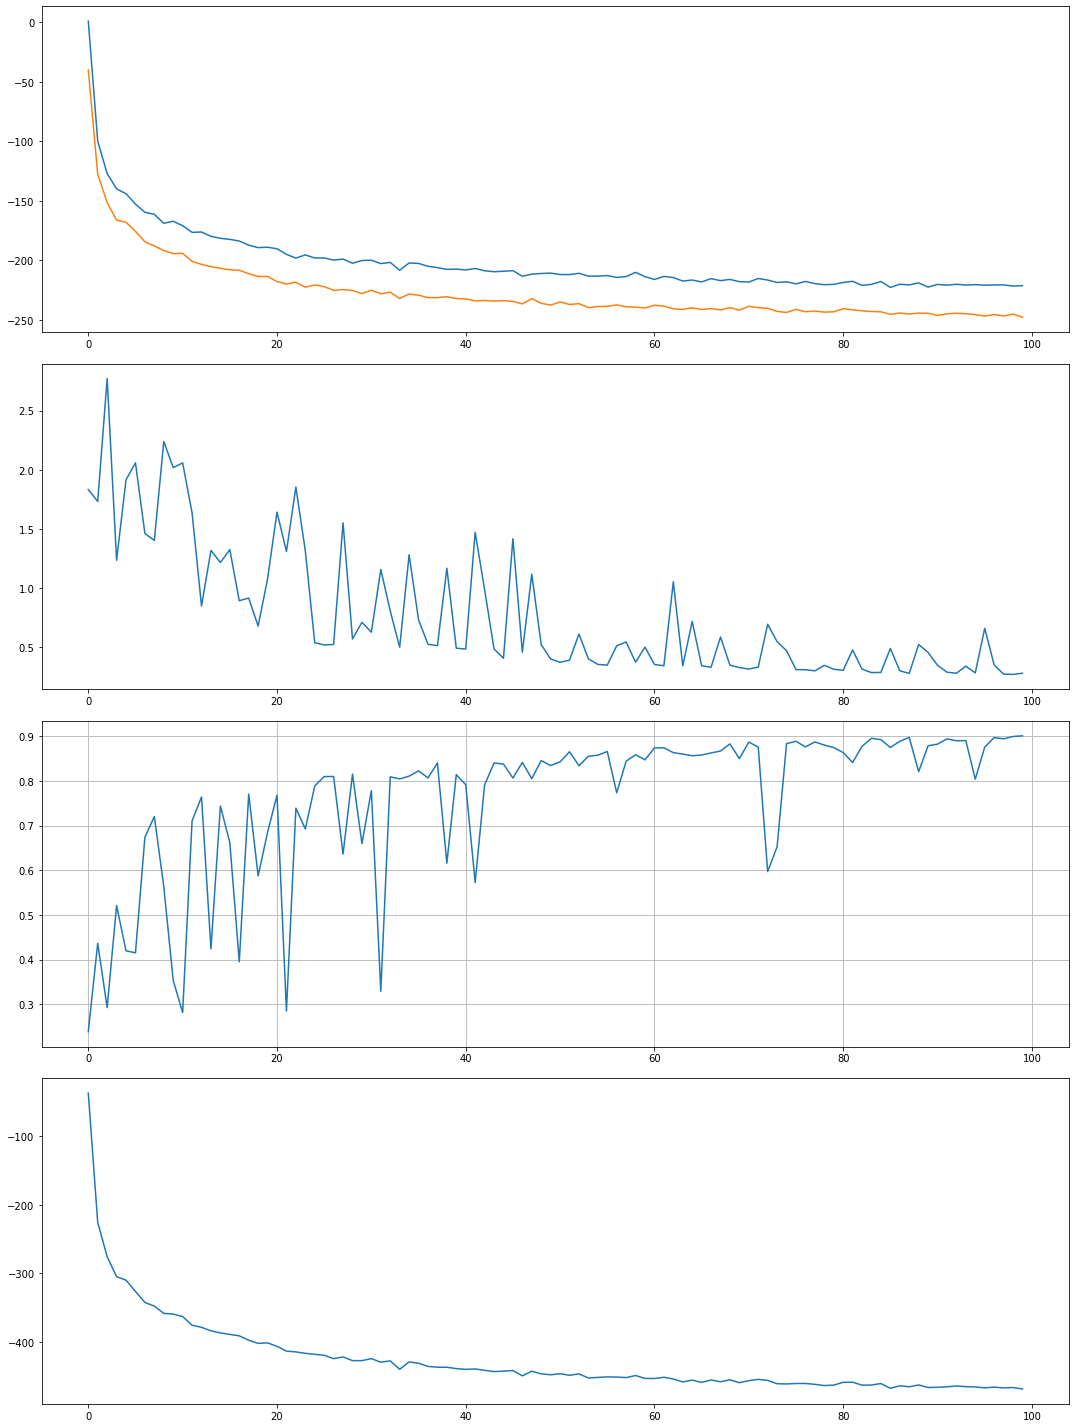

In [50]:
fig, axes = plt.subplots(4,1, figsize=(15,20))
fig.tight_layout()
axes[0].plot(np.array(sup_loss), label="supervised loss")
axes[0].plot(np.array(unsup_loss), label="unsupervised loss")

axes[1].plot(np.array(clf_loss), label="classification loss")

axes[2].plot(np.array(test_acc), label="accuracy")
axes[2].grid(True)

axes[3].plot(np.array(sup_loss) + np.array(unsup_loss)  + np.array(clf_loss), label=r"J^{alpha}")

plt.show()

In [54]:
#torch.save(ss_vae, "models_and_losses/SSVAE_CBN_lr-1e-4_100ep.pt")
#torch.save(ss_vae.state_dict(), "models_and_losses/SSVAE_CBN_lr-1e-4_state_dict_100ep.pt")
#torch.save(ss_vae.encoder_y, "models_and_losses/SSVAE_CBN_classifier_lr-1e-4_100ep.pt")
#torch.save(ss_vae.encoder_y.state_dict(), "models_and_losses/SSVAE_CBN_classifier_lr-1e-4_state_dict_100ep.pt")

In [57]:
for i in range(100,150): # 10 epochs for start
    start = time.time()
    epoch_sup_loss, epoch_unsup_loss = run_inference_for_epoch(data_loaders, losses)

    sup_loss.append(epoch_sup_loss[0]/sup_num)
    clf_loss.append(epoch_sup_loss[1]/sup_num)
    unsup_loss.append(epoch_unsup_loss[0]/unsup_num)

    test_accuracy = get_accuracy(data_loaders["test"], ss_vae.encoder_y)
    test_acc.append(test_accuracy)

    
    print("Epoch [{}/{}], time {:.2f}s, sup_loss:{:.4f}, sup_clf_loss:{:.4f}, unsup_loss:{:.4f}, test_accuracy:{:.4f}"\
          .format(i+1, 150, time.time()-start, sup_loss[-1], clf_loss[-1], unsup_loss[-1], test_accuracy))

Epoch [101/150], time 110.15s, sup_loss:-220.7204, sup_clf_loss:0.5288, unsup_loss:-245.7946, test_accuracy:0.8973
Epoch [102/150], time 109.95s, sup_loss:-221.7937, sup_clf_loss:0.2699, unsup_loss:-247.8917, test_accuracy:0.8955
Epoch [103/150], time 112.07s, sup_loss:-223.1669, sup_clf_loss:0.2653, unsup_loss:-247.0171, test_accuracy:0.8975
Epoch [104/150], time 116.04s, sup_loss:-222.9911, sup_clf_loss:0.2639, unsup_loss:-245.6354, test_accuracy:0.8992
Epoch [105/150], time 119.98s, sup_loss:-222.7225, sup_clf_loss:0.4212, unsup_loss:-246.4071, test_accuracy:0.8900
Epoch [106/150], time 111.19s, sup_loss:-223.1916, sup_clf_loss:0.2698, unsup_loss:-246.7125, test_accuracy:0.8945
Epoch [107/150], time 111.22s, sup_loss:-223.1419, sup_clf_loss:0.3160, unsup_loss:-247.3233, test_accuracy:0.8897
Epoch [108/150], time 114.42s, sup_loss:-221.3698, sup_clf_loss:0.2596, unsup_loss:-248.7618, test_accuracy:0.8951
Epoch [109/150], time 118.22s, sup_loss:-225.0509, sup_clf_loss:0.2767, unsup_lo

In [61]:
for i in range(150,160): # 10 epochs for start
    start = time.time()
    epoch_sup_loss, epoch_unsup_loss = run_inference_for_epoch(data_loaders, losses)

    sup_loss.append(epoch_sup_loss[0]/sup_num)
    clf_loss.append(epoch_sup_loss[1]/sup_num)
    unsup_loss.append(epoch_unsup_loss[0]/unsup_num)

    test_accuracy = get_accuracy(data_loaders["test"], ss_vae.encoder_y)
    test_acc.append(test_accuracy)

    
    print("Epoch [{}/{}], time {:.2f}s, sup_loss:{:.4f}, sup_clf_loss:{:.4f}, unsup_loss:{:.4f}, test_accuracy:{:.4f}"\
          .format(i+1, 150, time.time()-start, sup_loss[-1], clf_loss[-1], unsup_loss[-1], test_accuracy))

Epoch [151/150], time 109.92s, sup_loss:-229.5282, sup_clf_loss:0.2242, unsup_loss:-253.4866, test_accuracy:0.8948
Epoch [152/150], time 108.69s, sup_loss:-229.5477, sup_clf_loss:0.2898, unsup_loss:-250.8673, test_accuracy:0.9138
Epoch [153/150], time 110.01s, sup_loss:-229.2763, sup_clf_loss:0.2226, unsup_loss:-251.3576, test_accuracy:0.9078
Epoch [154/150], time 113.12s, sup_loss:-229.1439, sup_clf_loss:0.2230, unsup_loss:-250.6940, test_accuracy:0.9104
Epoch [155/150], time 110.17s, sup_loss:-228.1710, sup_clf_loss:0.2138, unsup_loss:-252.1126, test_accuracy:0.8972
Epoch [156/150], time 114.20s, sup_loss:-229.9099, sup_clf_loss:0.2227, unsup_loss:-253.2913, test_accuracy:0.9140
Epoch [157/150], time 107.87s, sup_loss:-227.6420, sup_clf_loss:0.2146, unsup_loss:-252.1043, test_accuracy:0.9121
Epoch [158/150], time 107.94s, sup_loss:-228.6852, sup_clf_loss:0.2186, unsup_loss:-252.1643, test_accuracy:0.9074
Epoch [159/150], time 107.03s, sup_loss:-228.7577, sup_clf_loss:0.3647, unsup_lo

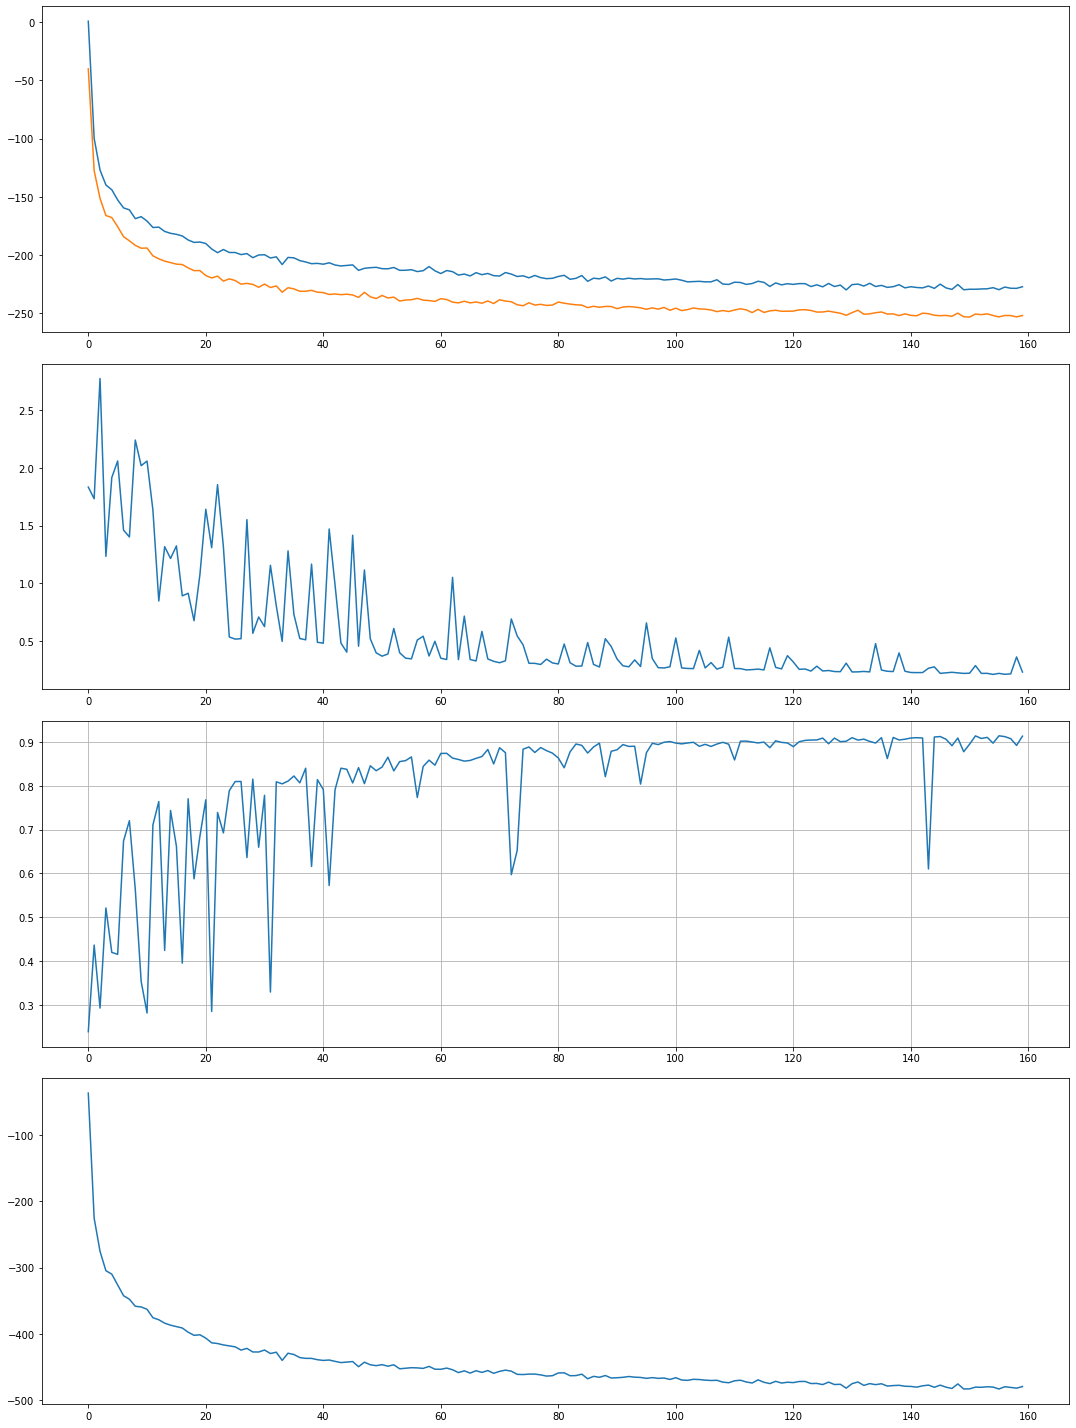

In [62]:
fig, axes = plt.subplots(4,1, figsize=(15,20))
fig.tight_layout()
axes[0].plot(np.array(sup_loss), label="supervised loss")
axes[0].plot(np.array(unsup_loss), label="unsupervised loss")

axes[1].plot(np.array(clf_loss), label="classification loss")

axes[2].plot(np.array(test_acc), label="accuracy")
axes[2].grid(True)

axes[3].plot(np.array(sup_loss) + np.array(unsup_loss)  + np.array(clf_loss), label=r"J^{alpha}")

plt.show()

In [55]:
import pandas as pd

df = pd.DataFrame({"supervised_loss":sup_loss, "unsupervised_loss":unsup_loss, "classification_loss":clf_loss,"test_accuracy":test_acc})
df.head()

,supervised_loss,unsupervised_loss,classification_loss,test_accuracy
0,0.976038,-40.044250,1.832728,0.238755
1,-99.865471,-127.604578,1.732039,0.436392
2,-127.015881,-151.399563,2.771500,0.292678
3,-139.886544,-166.119354,1.234275,0.521108
4,-143.956220,-167.912830,1.915163,0.419750


In [70]:
#torch.save(ss_vae, "models_and_losses/SSVAE_CBN_lr-1e-4_160ep.pt")
#torch.save(ss_vae.state_dict(), "models_and_losses/SSVAE_CBN_lr-1e-4_state_dict_160ep.pt")
#torch.save(ss_vae.encoder_y, "models_and_losses/SSVAE_CBN_classifier_lr-1e-4_160ep.pt")
#torch.save(ss_vae.encoder_y.state_dict(), "models_and_losses/SSVAE_CBN_classifier_lr-1e-4_state_dict_160ep.pt")

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SSVAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VariationalLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvTransposeDecoderOutput. It won't be chec

In [69]:
#df.to_csv("models_and_losses/SSVAE_CBN_lr-1e-4_160ep_losses.csv")

In [33]:
assert 1==0

AssertionError: 

In [63]:
ss_vae.encoder_y.eval()
final_test_accuracy = get_accuracy(data_loaders["test"], ss_vae.encoder_y)
ss_vae.encoder_y.train()

Sequential(
  (0): Reshape()
  (1): Conv1d(1, 16, kernel_size=(6,), stride=(2,), bias=False)
  (2): PReLU(num_parameters=1)
  (3): Conv1d(16, 32, kernel_size=(4,), stride=(2,), bias=False)
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): PReLU(num_parameters=1)
  (6): Conv1d(32, 64, kernel_size=(4,), stride=(2,), bias=False)
  (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): PReLU(num_parameters=1)
  (9): Flatten()
  (10): Linear(in_features=1152, out_features=256, bias=True)
  (11): PReLU(num_parameters=1)
  (12): Linear(in_features=256, out_features=4, bias=True)
  (13): Softmax(dim=1)
)

In [64]:
final_test_accuracy

0.9147673467630854

In [65]:
pred = ss_vae.encoder_y(torch.tensor(X_test).float().cuda())

In [66]:
pred = np.argmax(pred.cpu().detach().numpy(), axis=1)

In [67]:
f1_score(y_true=y_test, y_pred=pred,average="macro")

0.8717763075935387

In [68]:
cf1 = confusion_matrix(y_true=y_test, y_pred=pred) # x_axis = predicted, y_axis = ground_truth
cf1

array([[3781,  304,   28,  122],
       [ 419, 9889,   36,  101],
       [  26,   31,  408,   14],
       [ 224,   90,   12, 1251]], dtype=int64)

     array([[3808,  265,   25,  137],
           [ 414, 9883,   35,  113],
           [  22,   34,  404,   19],
           [ 187,  102,   11, 1277]], dtype=int64)